In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import csv
import warnings
warnings.filterwarnings('ignore')
import os
import glob
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="Fado")
import ast
import scipy.io
import cftime
import pickle
import shutil
from pathlib import Path

In [2]:
current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
Data_directory = parent_directory + '/Data/'
NC_directory = parent_directory + '/Data/NCFiles/Historical/'

In [3]:
print('Getting Coordinates...')
if Path(Data_directory+"/CoordinateData/lat_Value_HR.pkl").exists():
    with open(Data_directory+"/CoordinateData/lat_Value_HR.pkl", 'rb') as file:
        lat_Value_HR = pickle.load(file)
    with open(Data_directory+"/CoordinateData/lon_Value_HR.pkl", 'rb') as file:
        lon_Value_HR = pickle.load(file)
    with open(Data_directory+"/CoordinateData/lat_Value_LR.pkl", 'rb') as file:
        lat_Value_LR = pickle.load(file)
    with open(Data_directory+"/CoordinateData/lon_Value_LR.pkl", 'rb') as file:
        lon_Value_LR = pickle.load(file)
else:
    dataHR = xr.open_dataset(NC_directory+'/CESM_HR_RCP85_ENS01_Climate-Power_CONUS_20002020.nc')
    lat_Value_HR = dataHR.coords['lat'].values
    lon_Value_HR = dataHR.coords['lon'].values
    dataLR = xr.open_dataset(NC_directory+'/CESM_LR_RCP85_ENS01_Climate-Power_CONUS_20002020.nc')
    lat_Value_LR = dataLR.coords['lat'].values
    lon_Value_LR = dataLR.coords['lon'].values
    dataHR.close()
    dataLR.close()
    with open(Data_directory+"/CoordinateData/lat_Value_HR.pkl", 'wb') as file:
        pickle.dump(lat_Value_HR, file)
    with open(Data_directory+"/CoordinateData/lon_Value_HR.pkl", 'wb') as file:
        pickle.dump(lon_Value_HR, file)
    with open(Data_directory+"/CoordinateData/lat_Value_LR.pkl", 'wb') as file:
        pickle.dump(lat_Value_LR, file)
    with open(Data_directory+"/CoordinateData/lon_Value_LR.pkl", 'wb') as file:
        pickle.dump(lon_Value_LR, file)

Getting Coordinates...


In [4]:
def CheckCoordinate(lat , lon):
    location = geolocator.reverse((lat, lon-360), exactly_one=True)
    if location:
        address = location.raw.get("address", {})
        state = address.get("state")
        if state and (state.lower() == "texas" or state.lower() == "tx"):
            county = address.get("county")
            return True , county
    return False , 0

In [5]:
print("Filtering data...")
TexasList_dir = Data_directory+'/TexasDict.pkl'
if Path(TexasList_dir).exists():
    with open(TexasList_dir, 'rb') as file:
        TexasList = pickle.load(file)
else:
    TexasList = {}
    for lat_val in lat_Value_HR:
        for lon_val in lon_Value_HR:
            if 25<=lat_val<=38 and -107<=lon_val-360<=-92:
            #if 30<=lat_val<=38 and -102.25<=lon_val-360<=-92:
                key = (lat_val , lon_val)
                status , county = CheckCoordinate(lat_val , lon_val)
                if status:
                    TexasList[key] = [county]
                    print((lat_val , lon_val),' Exists! and in: ',county)
    with open(TexasList_dir, 'wb') as file:
        pickle.dump(TexasList, file)

Filtering data...


In [6]:
print("Creating Bias Correction Data...")
## Create Bias Correction df - ind: lon and col: lat
mat_data = scipy.io.loadmat(NC_directory + '/bias_correct_coefficients.mat')

bc_HR = mat_data['bc_HR']
bc_HR_df = pd.DataFrame(bc_HR)
bc_HR_df.columns = lat_Value_HR
bc_HR_df = bc_HR_df.set_index(lon_Value_HR)

bc_LR = mat_data['bc_LR']
bc_LR_df = pd.DataFrame(bc_LR)
bc_LR_df.columns = lat_Value_LR
bc_LR_df = bc_LR_df.set_index(lon_Value_LR)

Creating Bias Correction Data...


In [7]:
##Convert Historical Data into a DataFrame
filename = parent_directory + '/Data/NCFiles/Historical/Real/ERA5_WindSpeed100m_2000_2020.nc'
print('Processing: ' + filename)
datasetHist = xr.open_dataset(filename)
#lat_Value_Hist = datasetHist.coords['latitude'].values
#lon_Value_Hist = datasetHist.coords['longitude'].values

Processing: /scratch/user/fatemehdoudi/WindDroughtProject/Data/NCFiles/Historical/Real/ERA5_WindSpeed100m_2000_2020.nc


In [12]:
# Create a mask for Feb 29 in leap years
mask_feb29 = (datasetHist['time'].dt.month == 2) & (datasetHist['time'].dt.day == 29)
datasetHist_noLeap = datasetHist.where(~mask_feb29, drop=True)

# Season:

SeasonDict = {'Spring':[4,5,6],'Summer':[7,8,9],'Fall':[10,11,12],'Winter':[1,2,3]}
months = datasetHist_noLeap['time'].dt.month
datasetHist_noLeap_Spring = datasetHist_noLeap.where((months >= min(SeasonDict['Spring'])) & (months <= max(SeasonDict['Spring'])), drop=True)
datasetHist_noLeap_Summer = datasetHist_noLeap.where((months >= min(SeasonDict['Summer'])) & (months <= max(SeasonDict['Summer'])), drop=True)
datasetHist_noLeap_Fall = datasetHist_noLeap.where((months >= min(SeasonDict['Fall'])) & (months <= max(SeasonDict['Fall'])), drop=True)
datasetHist_noLeap_Winter = datasetHist_noLeap.where((months >= min(SeasonDict['Winter'])) & (months <= max(SeasonDict['Winter'])), drop=True)


In [13]:
# No 2002
mask_2002 = (datasetHist_noLeap['time'].dt.year == 2002)
dataHist_no2002 = datasetHist_noLeap.where(~mask_2002, drop=True)
# Season:
months = dataHist_no2002['time'].dt.month
dataHist_no2002_Spring = dataHist_no2002.where((months >= min(SeasonDict['Spring'])) & (months <= max(SeasonDict['Spring'])), drop=True)
dataHist_no2002_Summer = dataHist_no2002.where((months >= min(SeasonDict['Summer'])) & (months <= max(SeasonDict['Summer'])), drop=True)
dataHist_no2002_Fall = dataHist_no2002.where((months >= min(SeasonDict['Fall'])) & (months <= max(SeasonDict['Fall'])), drop=True)
dataHist_no2002_Winter = dataHist_no2002.where((months >= min(SeasonDict['Winter'])) & (months <= max(SeasonDict['Winter'])), drop=True)

In [ ]:
destination_path = NC_directory + '/Processed/'
file_list = os.listdir(NC_directory)
for filename in file_list:
    full_path = NC_directory + filename
    if filename.lower().endswith('.nc'):
        
        MSE_Dict_Spring = {} #4,5,6
        MSE_Dict_Summer = {} #7,8,9
        MSE_Dict_Fall = {} #10,11,12
        MSE_Dict_Winter = {} #1,2,3
        
        print('Processing: ' + filename+'...')
        dataset = xr.open_dataset(full_path)
        
        months = dataset['time'].dt.month
        dataset_Spring = dataset.where((months >= min(SeasonDict['Spring'])) & (months <= max(SeasonDict['Spring'])), drop=True)
        dataset_Summer = dataset.where((months >= min(SeasonDict['Summer'])) & (months <= max(SeasonDict['Summer'])), drop=True)
        dataset_Fall = dataset.where((months >= min(SeasonDict['Fall'])) & (months <= max(SeasonDict['Fall'])), drop=True)
        dataset_Winter = dataset.where((months >= min(SeasonDict['Winter'])) & (months <= max(SeasonDict['Winter'])), drop=True)

        for key , county in TexasList.items():
            Lat_val = key[0]
            Lon_val = key[1]
            if 'LR' in filename:
                est_Lat = round(Lat_val)
                est_Lon = round(Lon_val)
                Coefficient = bc_LR_df.loc[(est_Lon) , (est_Lat)]
            elif 'HR' in filename: 
                est_Lat = Lat_val
                est_Lon = Lon_val
                Coefficient = bc_HR_df.loc[(est_Lon) , (est_Lat)]
                
            for season , monthList in SeasonDict.items():
                if filename == 'CESM_LR_RCP85_ENS03_Climate-Power_CONUS_20002020.nc'or filename == 'CESM_LR_RCP85_ENS04_Climate-Power_CONUS_20002020.nc' or filename == 'CESM_LR_RCP85_ENS02_Climate-Power_CONUS_20002020.nc' :
                    if season == 'Spring':
                        dataHist = (dataHist_no2002_Spring['WSPD100'].sel(longitude = Lon_val, latitude = Lat_val, method='nearest')).values
                    elif season == 'Summer':
                        dataHist = (dataHist_no2002_Summer['WSPD100'].sel(longitude = Lon_val, latitude = Lat_val, method='nearest')).values
                    elif season == 'Fall':
                        dataHist = (dataHist_no2002_Fall['WSPD100'].sel(longitude = Lon_val, latitude = Lat_val, method='nearest')).values
                    elif season == 'Winter':
                        dataHist = (dataHist_no2002_Winter['WSPD100'].sel(longitude = Lon_val, latitude = Lat_val, method='nearest')).values
                else:      
                    if season == 'Spring':
                        dataHist = (datasetHist_noLeap_Spring['WSPD100'].sel(longitude = Lon_val, latitude = Lat_val, method='nearest')).values
                    elif season == 'Summer':
                        dataHist = (datasetHist_noLeap_Summer['WSPD100'].sel(longitude = Lon_val, latitude = Lat_val, method='nearest')).values
                    elif season == 'Fall':
                        dataHist = (datasetHist_noLeap_Fall['WSPD100'].sel(longitude = Lon_val, latitude = Lat_val, method='nearest')).values
                    elif season == 'Winter':
                        dataHist = (datasetHist_noLeap_Winter['WSPD100'].sel(longitude = Lon_val, latitude = Lat_val, method='nearest')).values
                
                if season == 'Spring':
                    data = (dataset_Spring['WSPD100'].sel(lon = Lon_val, lat = Lat_val, method='nearest')).values
                elif season == 'Summer':
                    data = (dataset_Summer['WSPD100'].sel(lon = Lon_val, lat = Lat_val, method='nearest')).values
                elif season == 'Fall':
                    data = (dataset_Fall['WSPD100'].sel(lon = Lon_val, lat = Lat_val, method='nearest')).values
                elif season == 'Winter':
                    data = (dataset_Winter['WSPD100'].sel(lon = Lon_val, lat = Lat_val, method='nearest')).values
                                
                squared_diff = np.sqrt((data - dataHist) ** 2)
                mse = np.mean(squared_diff)
                if season == 'Spring':
                    MSE_Dict_Spring[key] = [mse]
                elif season == 'Summer':
                    MSE_Dict_Summer[key] = [mse]
                elif season == 'Fall':
                    MSE_Dict_Fall[key] = [mse]
                elif season == 'Winter':
                    MSE_Dict_Winter[key] = [mse]

        print('Saving MSE as a pickle file...')
        with open(Data_directory + '/MSEFiles/' + 'MSE_Dict_Spring_' + filename + '.pkl', 'wb') as pickle_file:
            pickle.dump(MSE_Dict_Spring, pickle_file)
        with open(Data_directory + '/MSEFiles/' + 'MSE_Dict_Summer_' + filename + '.pkl', 'wb') as pickle_file:
            pickle.dump(MSE_Dict_Summer, pickle_file)
        with open(Data_directory + '/MSEFiles/' + 'MSE_Dict_Fall_' + filename + '.pkl', 'wb') as pickle_file:
            pickle.dump(MSE_Dict_Fall, pickle_file)
        with open(Data_directory + '/MSEFiles/' + 'MSE_Dict_Winter_' + filename + '.pkl', 'wb') as pickle_file:
            pickle.dump(MSE_Dict_Winter, pickle_file)

        print('Moving the processed File...')
        shutil.move(full_path, destination_path)

Processing: CESM_LR_RCP85_ENS01_Climate-Power_CONUS_20002020.nc...
Saving MSE as a pickle file...
Moving the processed File...
Processing: CESM_HR_RCP85_ENS01_Climate-Power_CONUS_20002020.nc...


In [8]:
##Processing MSE Files
MSE_directory = Data_directory+'/MSEFiles/'
file_list = os.listdir(MSE_directory)
MSE_dict_LR_Spring = {}
MSE_dict_HR_Spring = {}
for filename in file_list:
    if filename.endswith('.pkl') and ('Spring' in filename):
        with open(MSE_directory + filename, 'rb') as file:
            MSEData_Spring = pickle.load(file)
        for key , value in MSEData_Spring.items():
            mse = value[0]
            county = (TexasList[key])[0]
            county = county.replace(' County' , '')
            if 'LR' in filename:
                if county in MSE_dict_LR_Spring:
                    MSE_dict_LR_Spring[county].append(mse)
                else:
                    MSE_dict_LR_Spring[county] = [mse]
            elif 'HR' in filename:
                if county in MSE_dict_HR_Spring:
                    MSE_dict_HR_Spring[county].append(mse)
                else:
                    MSE_dict_HR_Spring[county] = [mse]

In [9]:
##Processing MSE Files
MSE_directory = Data_directory+'/MSEFiles/'
file_list = os.listdir(MSE_directory)
MSE_dict_LR_Summer = {}
MSE_dict_HR_Summer = {}
for filename in file_list:
    if filename.endswith('.pkl') and ('Summer' in filename):
        with open(MSE_directory + filename, 'rb') as file:
            MSEData_Summer = pickle.load(file)
        for key , value in MSEData_Summer.items():
            mse = value[0]
            county = (TexasList[key])[0]
            county = county.replace(' County' , '')
            if 'LR' in filename:
                if county in MSE_dict_LR_Summer:
                    MSE_dict_LR_Summer[county].append(mse)
                else:
                    MSE_dict_LR_Summer[county] = [mse]
            elif 'HR' in filename:
                if county in MSE_dict_HR_Summer:
                    MSE_dict_HR_Summer[county].append(mse)
                else:
                    MSE_dict_HR_Summer[county] = [mse]

In [10]:
##Processing MSE Files
MSE_directory = Data_directory+'/MSEFiles/'
file_list = os.listdir(MSE_directory)
MSE_dict_LR_Fall = {}
MSE_dict_HR_Fall = {}
for filename in file_list:
    if filename.endswith('.pkl') and ('Fall' in filename):
        with open(MSE_directory + filename, 'rb') as file:
            MSEData_Fall = pickle.load(file)
        for key , value in MSEData_Fall.items():
            mse = value[0]
            county = (TexasList[key])[0]
            county = county.replace(' County' , '')
            if 'LR' in filename:
                if county in MSE_dict_LR_Fall:
                    MSE_dict_LR_Fall[county].append(mse)
                else:
                    MSE_dict_LR_Fall[county] = [mse]
            elif 'HR' in filename:
                if county in MSE_dict_HR_Fall:
                    MSE_dict_HR_Fall[county].append(mse)
                else:
                    MSE_dict_HR_Fall[county] = [mse]

In [11]:
##Processing MSE Files
MSE_directory = Data_directory+'/MSEFiles/'
file_list = os.listdir(MSE_directory)
MSE_dict_LR_Winter = {}
MSE_dict_HR_Winter = {}
for filename in file_list:
    if filename.endswith('.pkl') and ('Winter' in filename):
        with open(MSE_directory + filename, 'rb') as file:
            MSEData_Winter = pickle.load(file)
        for key , value in MSEData_Winter.items():
            mse = value[0]
            county = (TexasList[key])[0]
            county = county.replace(' County' , '')
            if 'LR' in filename:
                if county in MSE_dict_LR_Winter:
                    MSE_dict_LR_Winter[county].append(mse)
                else:
                    MSE_dict_LR_Winter[county] = [mse]
            elif 'HR' in filename:
                if county in MSE_dict_HR_Winter:
                    MSE_dict_HR_Winter[county].append(mse)
                else:
                    MSE_dict_HR_Winter[county] = [mse]

In [12]:
Mean_MSE_LR_Spring = {}
Mean_MSE_HR_Spring = {}
for key , value in MSE_dict_LR_Spring.items():
    county = key
    MeanMSE = sum(value)/len(value)
    Mean_MSE_LR_Spring[county] = MeanMSE
for key , value in MSE_dict_HR_Spring.items():
    county = key
    MeanMSE = sum(value)/len(value)
    Mean_MSE_HR_Spring[county] = MeanMSE
#######################################
Mean_MSE_LR_Summer = {}
Mean_MSE_HR_Summer = {}
for key , value in MSE_dict_LR_Summer.items():
    county = key
    MeanMSE = sum(value)/len(value)
    Mean_MSE_LR_Summer[county] = MeanMSE
for key , value in MSE_dict_HR_Summer.items():
    county = key
    MeanMSE = sum(value)/len(value)
    Mean_MSE_HR_Summer[county] = MeanMSE
#######################################
Mean_MSE_LR_Fall = {}
Mean_MSE_HR_Fall = {}
for key , value in MSE_dict_LR_Fall.items():
    county = key
    MeanMSE = sum(value)/len(value)
    Mean_MSE_LR_Fall[county] = MeanMSE
for key , value in MSE_dict_HR_Fall.items():
    county = key
    MeanMSE = sum(value)/len(value)
    Mean_MSE_HR_Fall[county] = MeanMSE
#######################################
Mean_MSE_LR_Winter = {}
Mean_MSE_HR_Winter = {}
for key , value in MSE_dict_LR_Winter.items():
    county = key
    MeanMSE = sum(value)/len(value)
    Mean_MSE_LR_Winter[county] = MeanMSE
for key , value in MSE_dict_HR_Winter.items():
    county = key
    MeanMSE = sum(value)/len(value)
    Mean_MSE_HR_Winter[county] = MeanMSE


In [13]:
Max_MSE_LR_Spring = {}
Max_MSE_HR_Spring = {}
for key , value in MSE_dict_LR_Spring.items():
    county = key
    MaxMSE = sum(value)/len(value)
    Max_MSE_LR_Spring[county] = MaxMSE
for key , value in MSE_dict_HR_Spring.items():
    county = key
    MaxMSE = sum(value)/len(value)
    Max_MSE_HR_Spring[county] = MaxMSE
#######################################
Max_MSE_LR_Summer = {}
Max_MSE_HR_Summer = {}
for key , value in MSE_dict_LR_Summer.items():
    county = key
    MaxMSE = sum(value)/len(value)
    Max_MSE_LR_Summer[county] = MaxMSE
for key , value in MSE_dict_HR_Summer.items():
    county = key
    MaxMSE = sum(value)/len(value)
    Max_MSE_HR_Summer[county] = MaxMSE
#######################################
Max_MSE_LR_Fall = {}
Max_MSE_HR_Fall = {}
for key , value in MSE_dict_LR_Fall.items():
    county = key
    MaxMSE = sum(value)/len(value)
    Max_MSE_LR_Fall[county] = MaxMSE
for key , value in MSE_dict_HR_Fall.items():
    county = key
    MaxMSE = sum(value)/len(value)
    Max_MSE_HR_Fall[county] = MaxMSE
#######################################
Max_MSE_LR_Winter = {}
Max_MSE_HR_Winter  = {}
for key , value in MSE_dict_LR_Winter .items():
    county = key
    MaxMSE = sum(value)/len(value)
    Max_MSE_LR_Winter [county] = MaxMSE
for key , value in MSE_dict_HR_Winter .items():
    county = key
    MaxMSE = sum(value)/len(value)
    Max_MSE_HR_Winter [county] = MaxMSE
#######################################

In [14]:
Min_MSE_LR_Spring = {}
Min_MSE_HR_Spring = {}
for key , value in MSE_dict_LR_Spring.items():
    county = key
    MinMSE = sum(value)/len(value)
    Min_MSE_LR_Spring[county] = MinMSE
for key , value in MSE_dict_HR_Spring.items():
    county = key
    MinMSE = sum(value)/len(value)
    Min_MSE_HR_Spring[county] = MinMSE
#######################################
Min_MSE_LR_Summer = {}
Min_MSE_HR_Summer = {}
for key , value in MSE_dict_LR_Summer.items():
    county = key
    MinMSE = sum(value)/len(value)
    Min_MSE_LR_Summer[county] = MinMSE
for key , value in MSE_dict_HR_Summer.items():
    county = key
    MinMSE = sum(value)/len(value)
    Min_MSE_HR_Summer[county] = MinMSE
#######################################
Min_MSE_LR_Fall = {}
Min_MSE_HR_Fall = {}
for key , value in MSE_dict_LR_Fall.items():
    county = key
    MinMSE = sum(value)/len(value)
    Min_MSE_LR_Fall[county] = MinMSE
for key , value in MSE_dict_HR_Fall.items():
    county = key
    MinMSE = sum(value)/len(value)
    Min_MSE_HR_Fall[county] = MinMSE
#######################################
Min_MSE_LR_Winter = {}
Min_MSE_HR_Winter = {}
for key , value in MSE_dict_LR_Winter.items():
    county = key
    MinMSE = sum(value)/len(value)
    Min_MSE_LR_Winter[county] = MinMSE
for key , value in MSE_dict_HR_Winter.items():
    county = key
    MinMSE = sum(value)/len(value)
    Min_MSE_HR_Winter[county] = MinMSE
#######################################

In [17]:
std_MSE_LR_Spring = {}
std_MSE_HR_Spring = {}
for key , value in MSE_dict_LR_Spring.items():
    county = key
    std_MSE_LR_Spring[county] = np.std(value)
for key , value in MSE_dict_HR_Spring.items():
    county = key
    std_MSE_HR_Spring[county] = np.std(value)
#######################################
std_MSE_LR_Summer = {}
std_MSE_HR_Summer = {}
for key , value in MSE_dict_LR_Summer.items():
    county = key
    std_MSE_LR_Summer[county] = np.std(value)
for key , value in MSE_dict_HR_Summer.items():
    county = key
    std_MSE_HR_Summer[county] = np.std(value)
#######################################
std_MSE_LR_Fall = {}
std_MSE_HR_Fall = {}
for key , value in MSE_dict_LR_Fall.items():
    county = key
    std_MSE_LR_Fall[county] = np.std(value)
for key , value in MSE_dict_HR_Fall.items():
    county = key
    std_MSE_HR_Fall[county] = np.std(value)
#######################################
std_MSE_LR_Winter = {}
std_MSE_HR_Winter = {}
for key , value in MSE_dict_LR_Winter.items():
    county = key
    std_MSE_LR_Winter[county] = np.std(value)
for key , value in MSE_dict_HR_Winter.items():
    county = key
    std_MSE_HR_Winter[county] = np.std(value)
#######################################

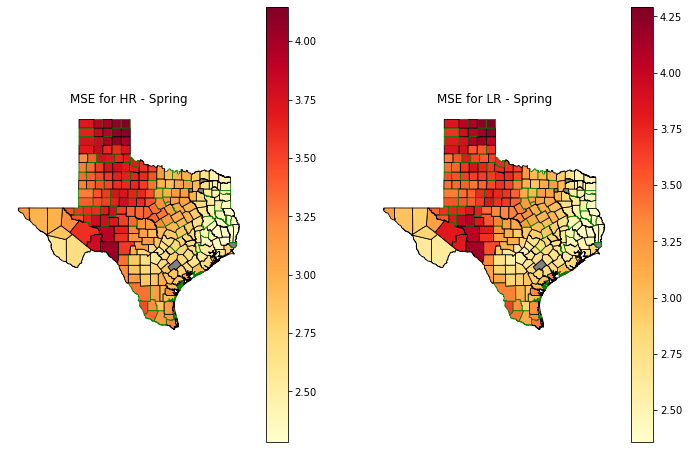

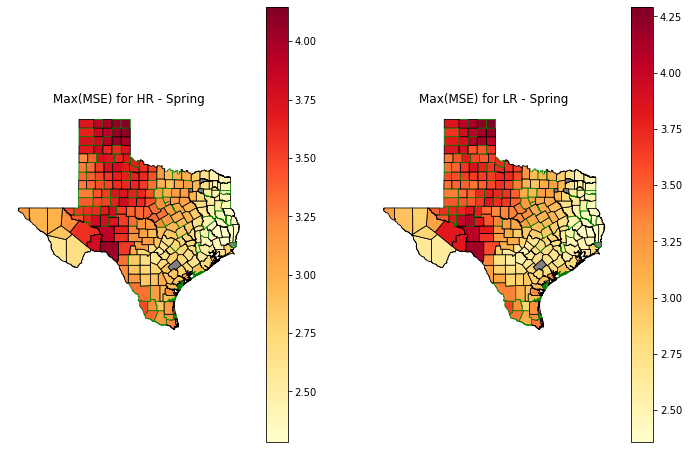

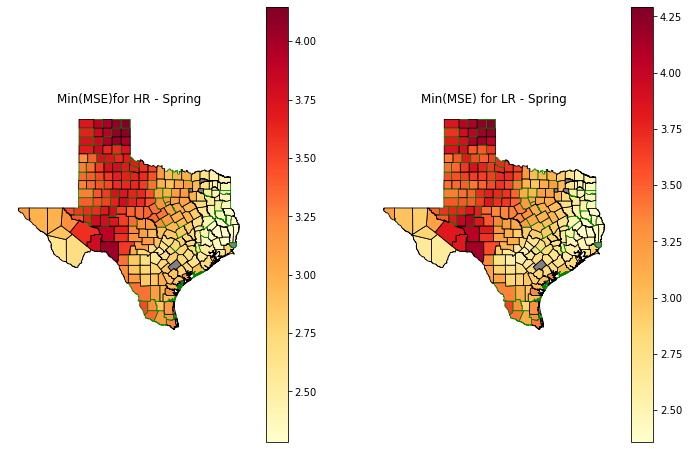

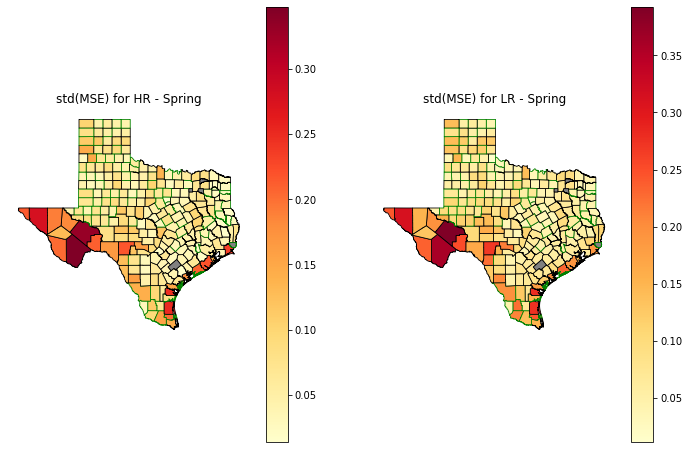

In [19]:
import geopandas as gpd
TxFarmData = pd.read_excel(Data_directory + "/WindFarmsTx.xlsx" , engine='openpyxl')
tx_counties = gpd.read_file(Data_directory + '/TexasInfo/County.shp')
county_edge_colors = {}
for name in tx_counties['CNTY_NM']:
    if name in TxFarmData['County'].values:
        county_edge_colors[name] = 'green'
    else:
        county_edge_colors[name] = 'black'
edge_colors = [county_edge_colors.get(county, 'black') for county in tx_counties['CNTY_NM']]
###Mean_MSE_data
tx_counties['Spring_HR_Mean'] = tx_counties['CNTY_NM'].map(Mean_MSE_HR_Spring)
tx_counties['Spring_LR_Mean'] = tx_counties['CNTY_NM'].map(Mean_MSE_LR_Spring)

tx_counties['Spring_HR_Max'] = tx_counties['CNTY_NM'].map(Max_MSE_HR_Spring)
tx_counties['Spring_LR_Max'] = tx_counties['CNTY_NM'].map(Max_MSE_LR_Spring)

tx_counties['Spring_HR_Min'] = tx_counties['CNTY_NM'].map(Min_MSE_HR_Spring)
tx_counties['Spring_LR_Min'] = tx_counties['CNTY_NM'].map(Min_MSE_LR_Spring)

tx_counties['Spring_HR_std'] = tx_counties['CNTY_NM'].map(std_MSE_HR_Spring)
tx_counties['Spring_LR_std'] = tx_counties['CNTY_NM'].map(std_MSE_LR_Spring)

fig, (ax1 , ax2) = plt.subplots(1, 2, figsize=(12, 8))
tx_counties.plot(column='Spring_HR_Mean', cmap='YlOrRd', linewidth=0.8, ax=ax1, edgecolor=edge_colors,missing_kwds={'color': 'gray'}, legend=True)
tx_counties.plot(column='Spring_LR_Mean', cmap='YlOrRd', linewidth=0.8, ax=ax2, edgecolor=edge_colors,missing_kwds={'color': 'gray'}, legend=True)
ax1.set_title('MSE for HR - Spring')
ax1.set_axis_off()
ax2.set_title('MSE for LR - Spring')
ax2.set_axis_off()

fig, (ax1 , ax2) = plt.subplots(1, 2, figsize=(12, 8))
tx_counties.plot(column='Spring_HR_Max', cmap='YlOrRd', linewidth=0.8, ax=ax1, edgecolor=edge_colors,missing_kwds={'color': 'gray'}, legend=True)
tx_counties.plot(column='Spring_LR_Max', cmap='YlOrRd', linewidth=0.8, ax=ax2, edgecolor=edge_colors,missing_kwds={'color': 'gray'}, legend=True)
ax1.set_title('Max(MSE) for HR - Spring')
ax1.set_axis_off()
ax2.set_title('Max(MSE) for LR - Spring')
ax2.set_axis_off()

fig, (ax1 , ax2) = plt.subplots(1, 2, figsize=(12, 8))
tx_counties.plot(column='Spring_HR_Min', cmap='YlOrRd', linewidth=0.8, ax=ax1, edgecolor=edge_colors,missing_kwds={'color': 'gray'}, legend=True)
tx_counties.plot(column='Spring_LR_Min', cmap='YlOrRd', linewidth=0.8, ax=ax2, edgecolor=edge_colors,missing_kwds={'color': 'gray'}, legend=True)
ax1.set_title('Min(MSE)for HR - Spring')
ax1.set_axis_off()
ax2.set_title('Min(MSE) for LR - Spring')
ax2.set_axis_off()

fig, (ax1 , ax2) = plt.subplots(1, 2, figsize=(12, 8))
tx_counties.plot(column='Spring_HR_std', cmap='YlOrRd', linewidth=0.8, ax=ax1, edgecolor=edge_colors,missing_kwds={'color': 'gray'}, legend=True)
tx_counties.plot(column='Spring_LR_std', cmap='YlOrRd', linewidth=0.8, ax=ax2, edgecolor=edge_colors,missing_kwds={'color': 'gray'}, legend=True)
ax1.set_title('std(MSE) for HR - Spring')
ax1.set_axis_off()
ax2.set_title('std(MSE) for LR - Spring')
ax2.set_axis_off()
#plt.savefig('texas_heatmap_.jpg')
plt.show()

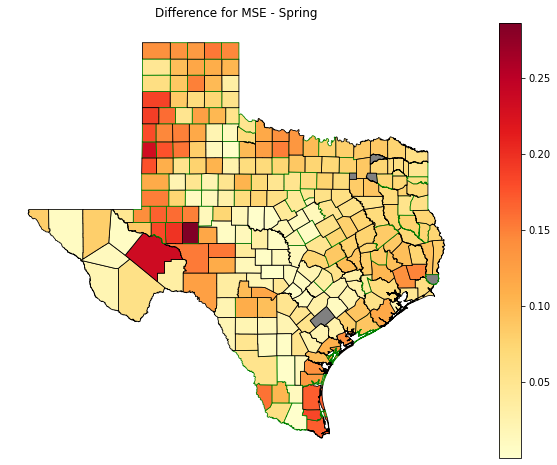

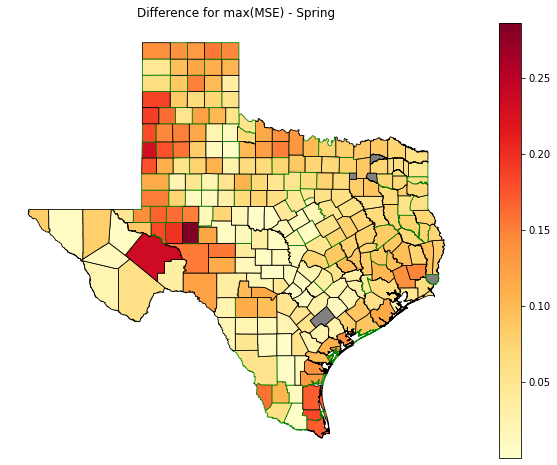

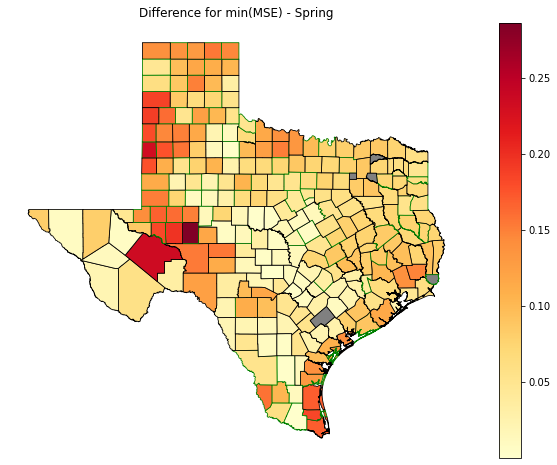

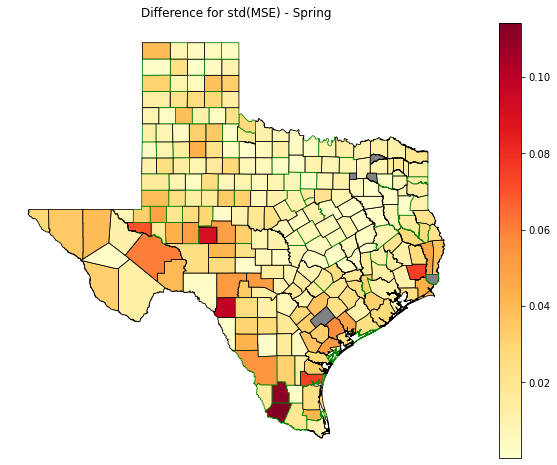

In [21]:
import geopandas as gpd
import matplotlib.pyplot as plt
diff_Mean = {}
for key,value in Mean_MSE_HR_Spring.items():
    HRval = value 
    LRval = Mean_MSE_LR_Spring[key]
    diff_Mean[key] = np.abs(HRval - LRval)
    
diff_Max = {}
for key,value in Max_MSE_HR_Spring.items():
    HRval = value 
    LRval = Max_MSE_LR_Spring[key]
    diff_Max[key] = np.abs(HRval - LRval)
    
diff_Min = {}
for key,value in Min_MSE_HR_Spring.items():
    HRval = value 
    LRval = Min_MSE_LR_Spring[key]
    diff_Min[key] = np.abs(HRval - LRval)
    
diff_std = {}
for key,value in std_MSE_HR_Spring.items():
    HRval = value 
    LRval = std_MSE_LR_Spring[key]
    diff_std[key] = np.abs(HRval - LRval)
    
tx_counties = gpd.read_file(Data_directory + '/TexasInfo/County.shp')
tx_counties['diff_Mean'] = tx_counties['CNTY_NM'].map(diff_Mean)
tx_counties['diff_Max'] = tx_counties['CNTY_NM'].map(diff_Max)
tx_counties['diff_Min'] = tx_counties['CNTY_NM'].map(diff_Min)
tx_counties['diff_std'] = tx_counties['CNTY_NM'].map(diff_std)

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
tx_counties.plot(column='diff_Mean', cmap='YlOrRd', linewidth=0.8, ax=ax, edgecolor=edge_colors,missing_kwds={'color': 'gray'}, legend=True)
ax.set_title('Difference for MSE - Spring')
ax.set_axis_off()

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
tx_counties.plot(column='diff_Max', cmap='YlOrRd', linewidth=0.8, ax=ax, edgecolor=edge_colors,missing_kwds={'color': 'gray'}, legend=True)
ax.set_title('Difference for max(MSE) - Spring')
ax.set_axis_off()

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
tx_counties.plot(column='diff_Min', cmap='YlOrRd', linewidth=0.8, ax=ax, edgecolor=edge_colors,missing_kwds={'color': 'gray'}, legend=True)
ax.set_title('Difference for min(MSE) - Spring')
ax.set_axis_off()

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
tx_counties.plot(column='diff_std', cmap='YlOrRd', linewidth=0.8, ax=ax, edgecolor=edge_colors,missing_kwds={'color': 'gray'}, legend=True)
ax.set_title('Difference for std(MSE) - Spring')
ax.set_axis_off()

plt.show()

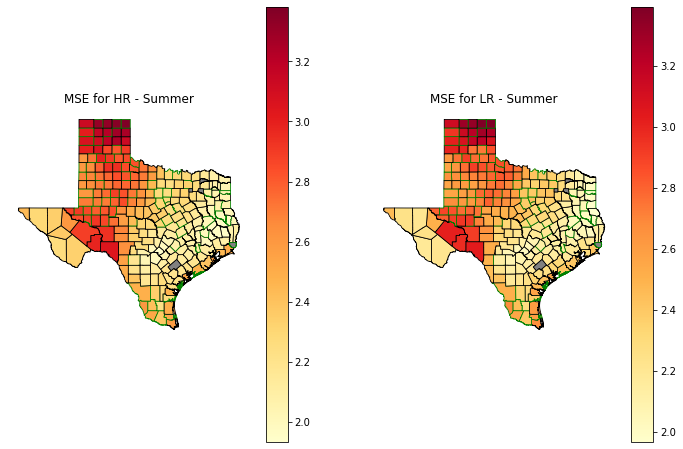

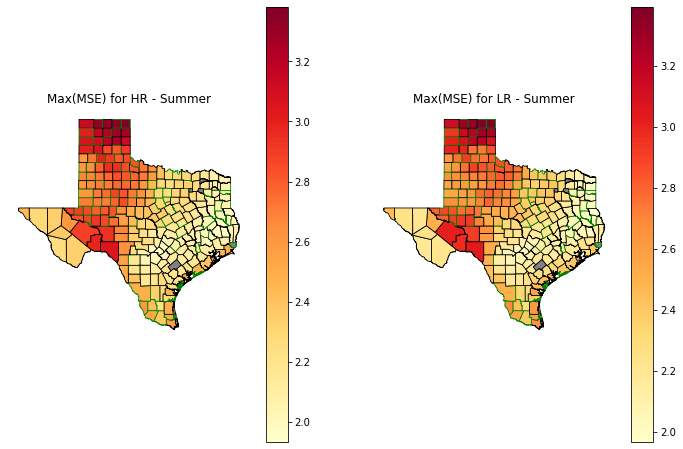

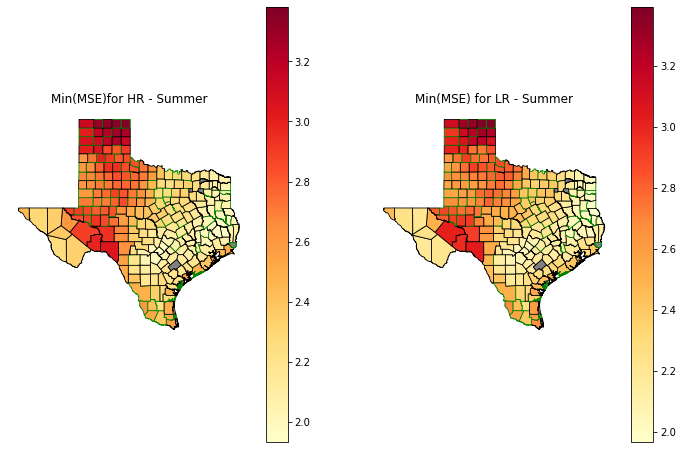

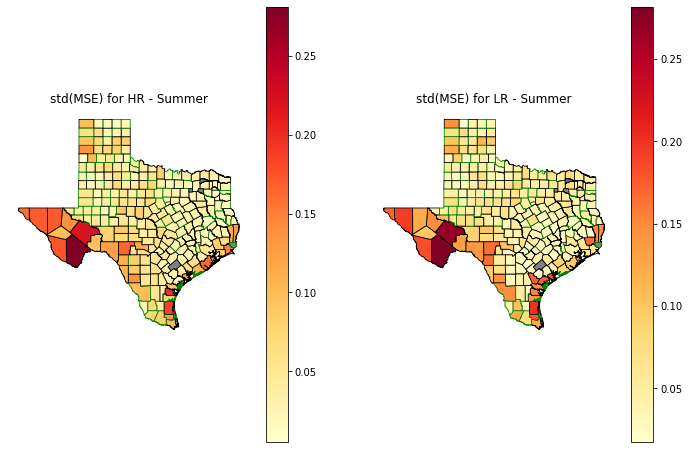

In [22]:
import geopandas as gpd
TxFarmData = pd.read_excel(Data_directory + "/WindFarmsTx.xlsx" , engine='openpyxl')
tx_counties = gpd.read_file(Data_directory + '/TexasInfo/County.shp')
county_edge_colors = {}
for name in tx_counties['CNTY_NM']:
    if name in TxFarmData['County'].values:
        county_edge_colors[name] = 'green'
    else:
        county_edge_colors[name] = 'black'
edge_colors = [county_edge_colors.get(county, 'black') for county in tx_counties['CNTY_NM']]
###Mean_MSE_data
tx_counties['Summer_HR_Mean'] = tx_counties['CNTY_NM'].map(Mean_MSE_HR_Summer)
tx_counties['Summer_LR_Mean'] = tx_counties['CNTY_NM'].map(Mean_MSE_LR_Summer)

tx_counties['Summer_HR_Max'] = tx_counties['CNTY_NM'].map(Max_MSE_HR_Summer)
tx_counties['Summer_LR_Max'] = tx_counties['CNTY_NM'].map(Max_MSE_LR_Summer)

tx_counties['Summer_HR_Min'] = tx_counties['CNTY_NM'].map(Min_MSE_HR_Summer)
tx_counties['Summer_LR_Min'] = tx_counties['CNTY_NM'].map(Min_MSE_LR_Summer)

tx_counties['Summer_HR_std'] = tx_counties['CNTY_NM'].map(std_MSE_HR_Summer)
tx_counties['Summer_LR_std'] = tx_counties['CNTY_NM'].map(std_MSE_LR_Summer)

fig, (ax1 , ax2) = plt.subplots(1, 2, figsize=(12, 8))
tx_counties.plot(column='Summer_HR_Mean', cmap='YlOrRd', linewidth=0.8, ax=ax1, edgecolor=edge_colors,missing_kwds={'color': 'gray'}, legend=True)
tx_counties.plot(column='Summer_LR_Mean', cmap='YlOrRd', linewidth=0.8, ax=ax2, edgecolor=edge_colors,missing_kwds={'color': 'gray'}, legend=True)
ax1.set_title('MSE for HR - Summer')
ax1.set_axis_off()
ax2.set_title('MSE for LR - Summer')
ax2.set_axis_off()

fig, (ax1 , ax2) = plt.subplots(1, 2, figsize=(12, 8))
tx_counties.plot(column='Summer_HR_Max', cmap='YlOrRd', linewidth=0.8, ax=ax1, edgecolor=edge_colors,missing_kwds={'color': 'gray'}, legend=True)
tx_counties.plot(column='Summer_LR_Max', cmap='YlOrRd', linewidth=0.8, ax=ax2, edgecolor=edge_colors,missing_kwds={'color': 'gray'}, legend=True)
ax1.set_title('Max(MSE) for HR - Summer')
ax1.set_axis_off()
ax2.set_title('Max(MSE) for LR - Summer')
ax2.set_axis_off()

fig, (ax1 , ax2) = plt.subplots(1, 2, figsize=(12, 8))
tx_counties.plot(column='Summer_HR_Min', cmap='YlOrRd', linewidth=0.8, ax=ax1, edgecolor=edge_colors,missing_kwds={'color': 'gray'}, legend=True)
tx_counties.plot(column='Summer_LR_Min', cmap='YlOrRd', linewidth=0.8, ax=ax2, edgecolor=edge_colors,missing_kwds={'color': 'gray'}, legend=True)
ax1.set_title('Min(MSE)for HR - Summer')
ax1.set_axis_off()
ax2.set_title('Min(MSE) for LR - Summer')
ax2.set_axis_off()

fig, (ax1 , ax2) = plt.subplots(1, 2, figsize=(12, 8))
tx_counties.plot(column='Summer_HR_std', cmap='YlOrRd', linewidth=0.8, ax=ax1, edgecolor=edge_colors,missing_kwds={'color': 'gray'}, legend=True)
tx_counties.plot(column='Summer_LR_std', cmap='YlOrRd', linewidth=0.8, ax=ax2, edgecolor=edge_colors,missing_kwds={'color': 'gray'}, legend=True)
ax1.set_title('std(MSE) for HR - Summer')
ax1.set_axis_off()
ax2.set_title('std(MSE) for LR - Summer')
ax2.set_axis_off()
#plt.savefig('texas_heatmap_.jpg')
plt.show()

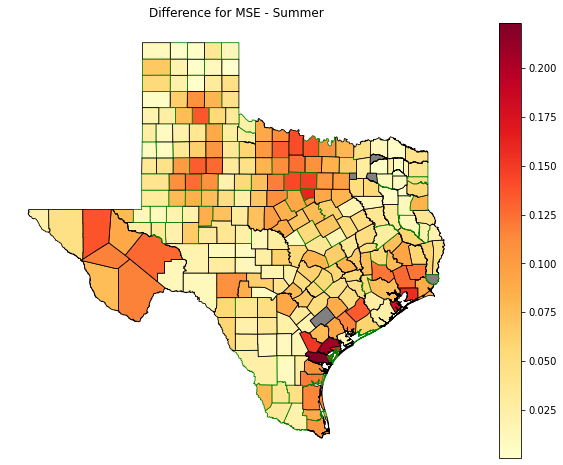

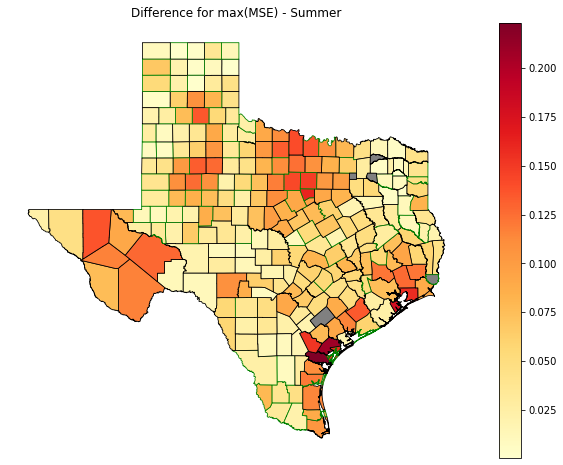

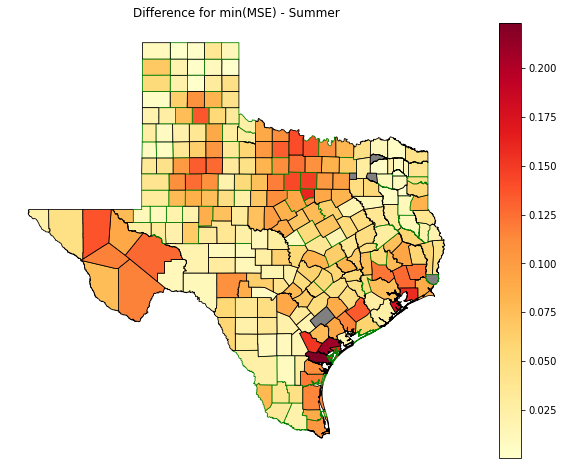

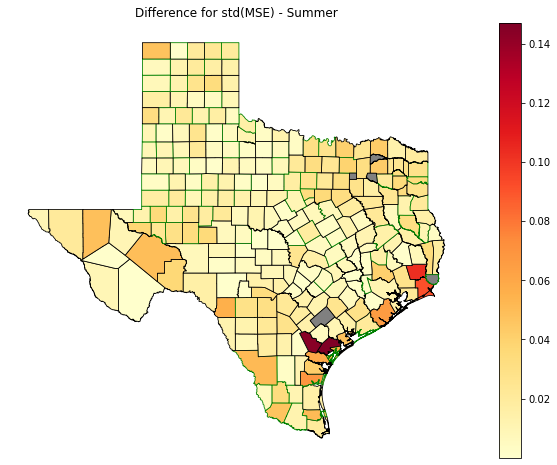

In [23]:
import geopandas as gpd
import matplotlib.pyplot as plt
diff_Mean = {}
for key,value in Mean_MSE_HR_Summer.items():
    HRval = value 
    LRval = Mean_MSE_LR_Summer[key]
    diff_Mean[key] = np.abs(HRval - LRval)
    
diff_Max = {}
for key,value in Max_MSE_HR_Summer.items():
    HRval = value 
    LRval = Max_MSE_LR_Summer[key]
    diff_Max[key] = np.abs(HRval - LRval)
    
diff_Min = {}
for key,value in Min_MSE_HR_Summer.items():
    HRval = value 
    LRval = Min_MSE_LR_Summer[key]
    diff_Min[key] = np.abs(HRval - LRval)
    
diff_std = {}
for key,value in std_MSE_HR_Summer.items():
    HRval = value 
    LRval = std_MSE_LR_Summer[key]
    diff_std[key] = np.abs(HRval - LRval)
    
tx_counties = gpd.read_file(Data_directory + '/TexasInfo/County.shp')
tx_counties['diff_Mean'] = tx_counties['CNTY_NM'].map(diff_Mean)
tx_counties['diff_Max'] = tx_counties['CNTY_NM'].map(diff_Max)
tx_counties['diff_Min'] = tx_counties['CNTY_NM'].map(diff_Min)
tx_counties['diff_std'] = tx_counties['CNTY_NM'].map(diff_std)

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
tx_counties.plot(column='diff_Mean', cmap='YlOrRd', linewidth=0.8, ax=ax, edgecolor=edge_colors,missing_kwds={'color': 'gray'}, legend=True)
ax.set_title('Difference for MSE - Summer')
ax.set_axis_off()

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
tx_counties.plot(column='diff_Max', cmap='YlOrRd', linewidth=0.8, ax=ax, edgecolor=edge_colors,missing_kwds={'color': 'gray'}, legend=True)
ax.set_title('Difference for max(MSE) - Summer')
ax.set_axis_off()

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
tx_counties.plot(column='diff_Min', cmap='YlOrRd', linewidth=0.8, ax=ax, edgecolor=edge_colors,missing_kwds={'color': 'gray'}, legend=True)
ax.set_title('Difference for min(MSE) - Summer')
ax.set_axis_off()

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
tx_counties.plot(column='diff_std', cmap='YlOrRd', linewidth=0.8, ax=ax, edgecolor=edge_colors,missing_kwds={'color': 'gray'}, legend=True)
ax.set_title('Difference for std(MSE) - Summer')
ax.set_axis_off()

plt.show()

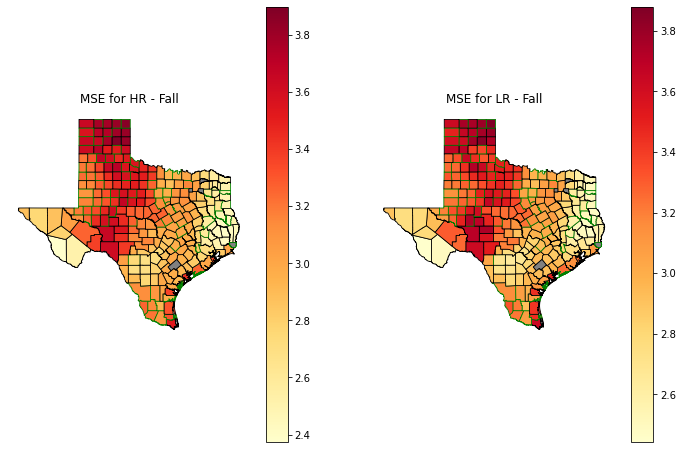

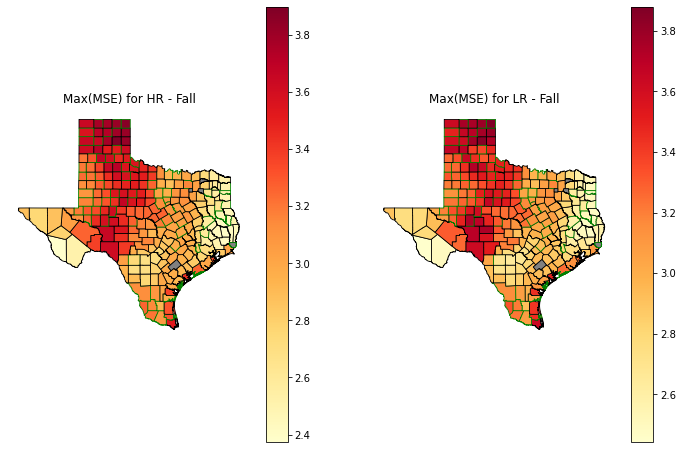

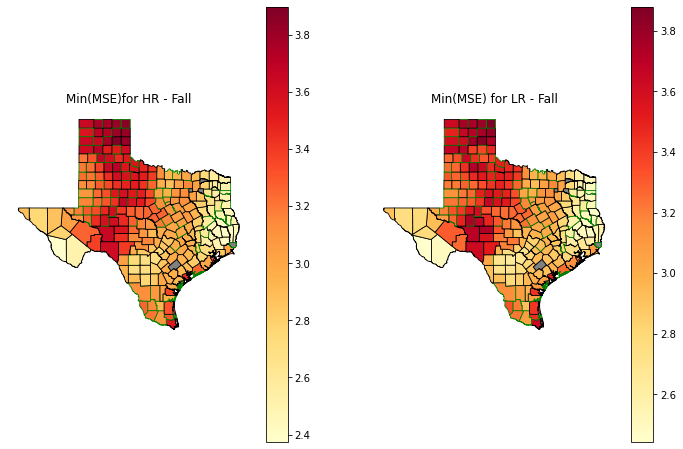

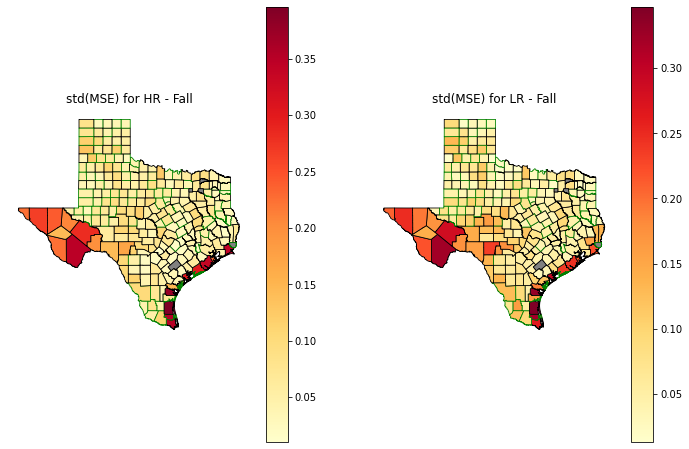

In [24]:
import geopandas as gpd
TxFarmData = pd.read_excel(Data_directory + "/WindFarmsTx.xlsx" , engine='openpyxl')
tx_counties = gpd.read_file(Data_directory + '/TexasInfo/County.shp')
county_edge_colors = {}
for name in tx_counties['CNTY_NM']:
    if name in TxFarmData['County'].values:
        county_edge_colors[name] = 'green'
    else:
        county_edge_colors[name] = 'black'
edge_colors = [county_edge_colors.get(county, 'black') for county in tx_counties['CNTY_NM']]
###Mean_MSE_data
tx_counties['Fall_HR_Mean'] = tx_counties['CNTY_NM'].map(Mean_MSE_HR_Fall)
tx_counties['Fall_LR_Mean'] = tx_counties['CNTY_NM'].map(Mean_MSE_LR_Fall)

tx_counties['Fall_HR_Max'] = tx_counties['CNTY_NM'].map(Max_MSE_HR_Fall)
tx_counties['Fall_LR_Max'] = tx_counties['CNTY_NM'].map(Max_MSE_LR_Fall)

tx_counties['Fall_HR_Min'] = tx_counties['CNTY_NM'].map(Min_MSE_HR_Fall)
tx_counties['Fall_LR_Min'] = tx_counties['CNTY_NM'].map(Min_MSE_LR_Fall)

tx_counties['Fall_HR_std'] = tx_counties['CNTY_NM'].map(std_MSE_HR_Fall)
tx_counties['Fall_LR_std'] = tx_counties['CNTY_NM'].map(std_MSE_LR_Fall)

fig, (ax1 , ax2) = plt.subplots(1, 2, figsize=(12, 8))
tx_counties.plot(column='Fall_HR_Mean', cmap='YlOrRd', linewidth=0.8, ax=ax1, edgecolor=edge_colors,missing_kwds={'color': 'gray'}, legend=True)
tx_counties.plot(column='Fall_LR_Mean', cmap='YlOrRd', linewidth=0.8, ax=ax2, edgecolor=edge_colors,missing_kwds={'color': 'gray'}, legend=True)
ax1.set_title('MSE for HR - Fall')
ax1.set_axis_off()
ax2.set_title('MSE for LR - Fall')
ax2.set_axis_off()

fig, (ax1 , ax2) = plt.subplots(1, 2, figsize=(12, 8))
tx_counties.plot(column='Fall_HR_Max', cmap='YlOrRd', linewidth=0.8, ax=ax1, edgecolor=edge_colors,missing_kwds={'color': 'gray'}, legend=True)
tx_counties.plot(column='Fall_LR_Max', cmap='YlOrRd', linewidth=0.8, ax=ax2, edgecolor=edge_colors,missing_kwds={'color': 'gray'}, legend=True)
ax1.set_title('Max(MSE) for HR - Fall')
ax1.set_axis_off()
ax2.set_title('Max(MSE) for LR - Fall')
ax2.set_axis_off()

fig, (ax1 , ax2) = plt.subplots(1, 2, figsize=(12, 8))
tx_counties.plot(column='Fall_HR_Min', cmap='YlOrRd', linewidth=0.8, ax=ax1, edgecolor=edge_colors,missing_kwds={'color': 'gray'}, legend=True)
tx_counties.plot(column='Fall_LR_Min', cmap='YlOrRd', linewidth=0.8, ax=ax2, edgecolor=edge_colors,missing_kwds={'color': 'gray'}, legend=True)
ax1.set_title('Min(MSE)for HR - Fall')
ax1.set_axis_off()
ax2.set_title('Min(MSE) for LR - Fall')
ax2.set_axis_off()

fig, (ax1 , ax2) = plt.subplots(1, 2, figsize=(12, 8))
tx_counties.plot(column='Fall_HR_std', cmap='YlOrRd', linewidth=0.8, ax=ax1, edgecolor=edge_colors,missing_kwds={'color': 'gray'}, legend=True)
tx_counties.plot(column='Fall_LR_std', cmap='YlOrRd', linewidth=0.8, ax=ax2, edgecolor=edge_colors,missing_kwds={'color': 'gray'}, legend=True)
ax1.set_title('std(MSE) for HR - Fall')
ax1.set_axis_off()
ax2.set_title('std(MSE) for LR - Fall')
ax2.set_axis_off()
#plt.savefig('texas_heatmap_.jpg')
plt.show()

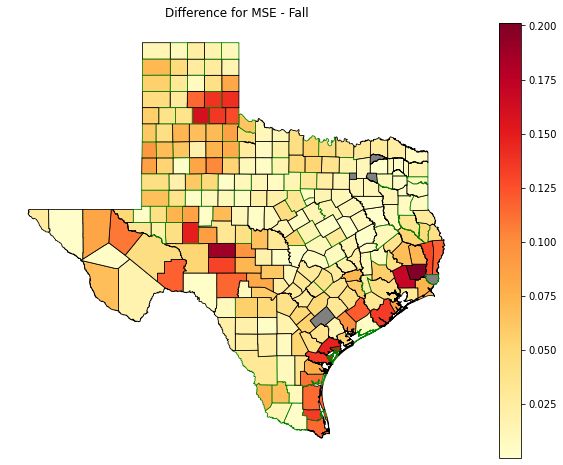

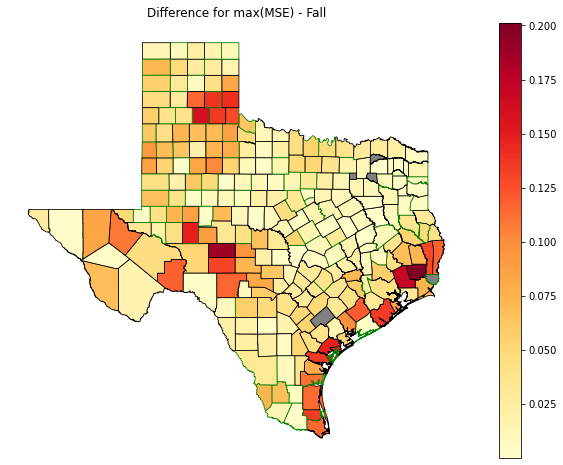

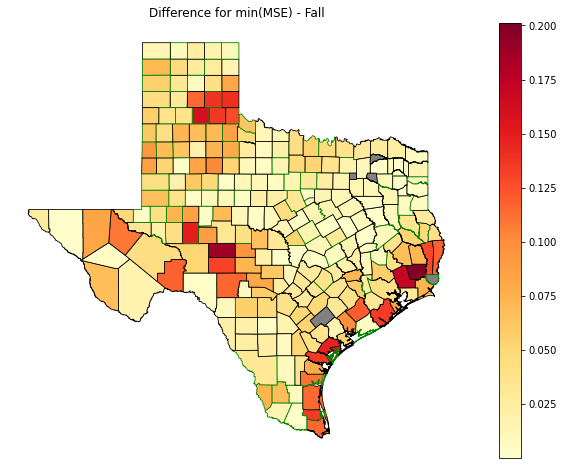

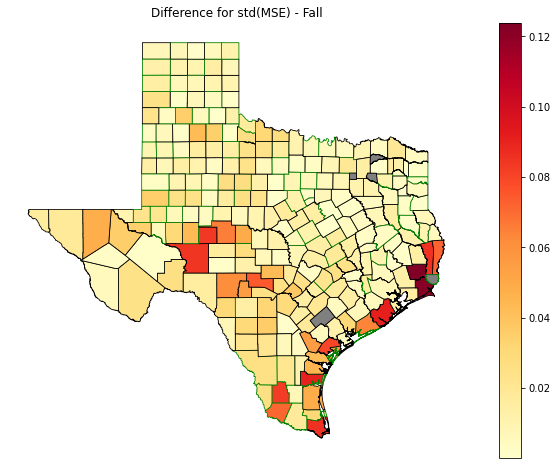

In [25]:
import geopandas as gpd
import matplotlib.pyplot as plt
diff_Mean = {}
for key,value in Mean_MSE_HR_Fall.items():
    HRval = value 
    LRval = Mean_MSE_LR_Fall[key]
    diff_Mean[key] = np.abs(HRval - LRval)
    
diff_Max = {}
for key,value in Max_MSE_HR_Fall.items():
    HRval = value 
    LRval = Max_MSE_LR_Fall[key]
    diff_Max[key] = np.abs(HRval - LRval)
    
diff_Min = {}
for key,value in Min_MSE_HR_Fall.items():
    HRval = value 
    LRval = Min_MSE_LR_Fall[key]
    diff_Min[key] = np.abs(HRval - LRval)
    
diff_std = {}
for key,value in std_MSE_HR_Fall.items():
    HRval = value 
    LRval = std_MSE_LR_Fall[key]
    diff_std[key] = np.abs(HRval - LRval)
    
tx_counties = gpd.read_file(Data_directory + '/TexasInfo/County.shp')
tx_counties['diff_Mean'] = tx_counties['CNTY_NM'].map(diff_Mean)
tx_counties['diff_Max'] = tx_counties['CNTY_NM'].map(diff_Max)
tx_counties['diff_Min'] = tx_counties['CNTY_NM'].map(diff_Min)
tx_counties['diff_std'] = tx_counties['CNTY_NM'].map(diff_std)

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
tx_counties.plot(column='diff_Mean', cmap='YlOrRd', linewidth=0.8, ax=ax, edgecolor=edge_colors,missing_kwds={'color': 'gray'}, legend=True)
ax.set_title('Difference for MSE - Fall')
ax.set_axis_off()

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
tx_counties.plot(column='diff_Max', cmap='YlOrRd', linewidth=0.8, ax=ax, edgecolor=edge_colors,missing_kwds={'color': 'gray'}, legend=True)
ax.set_title('Difference for max(MSE) - Fall')
ax.set_axis_off()

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
tx_counties.plot(column='diff_Min', cmap='YlOrRd', linewidth=0.8, ax=ax, edgecolor=edge_colors,missing_kwds={'color': 'gray'}, legend=True)
ax.set_title('Difference for min(MSE) - Fall')
ax.set_axis_off()

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
tx_counties.plot(column='diff_std', cmap='YlOrRd', linewidth=0.8, ax=ax, edgecolor=edge_colors,missing_kwds={'color': 'gray'}, legend=True)
ax.set_title('Difference for std(MSE) - Fall')
ax.set_axis_off()

plt.show()

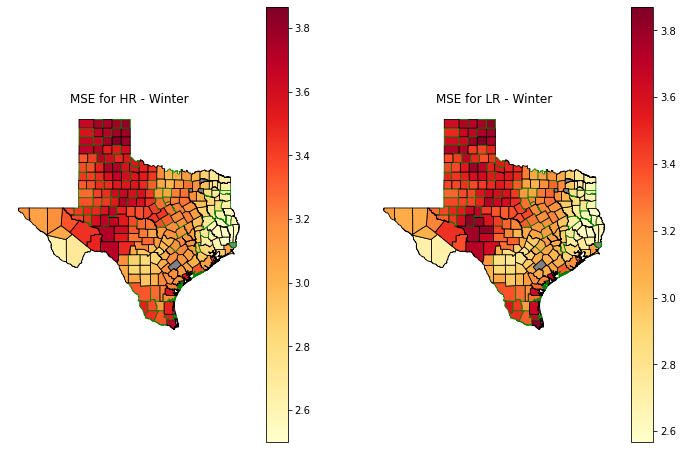

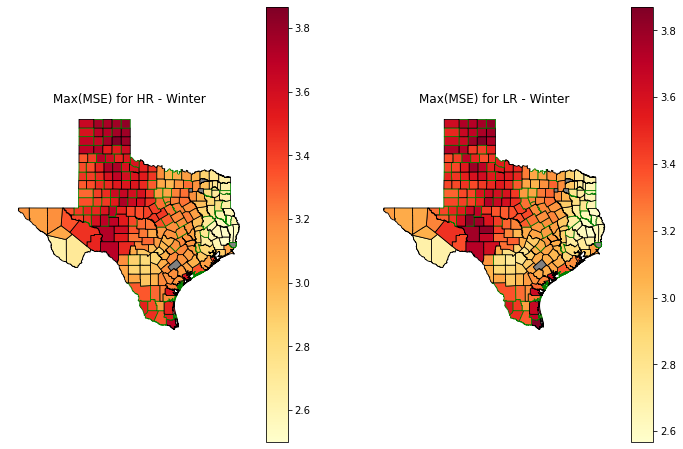

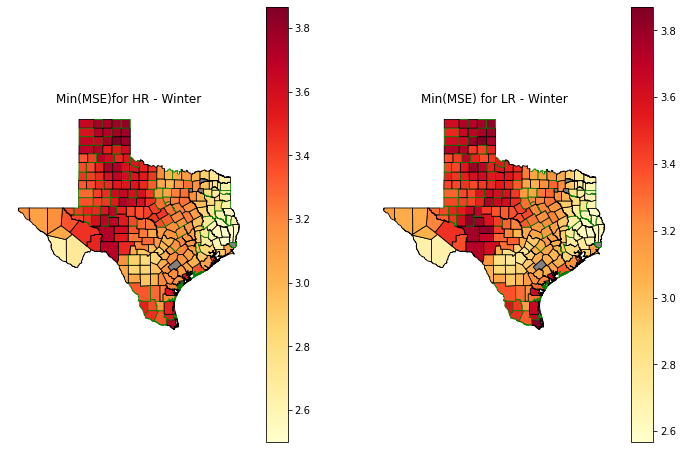

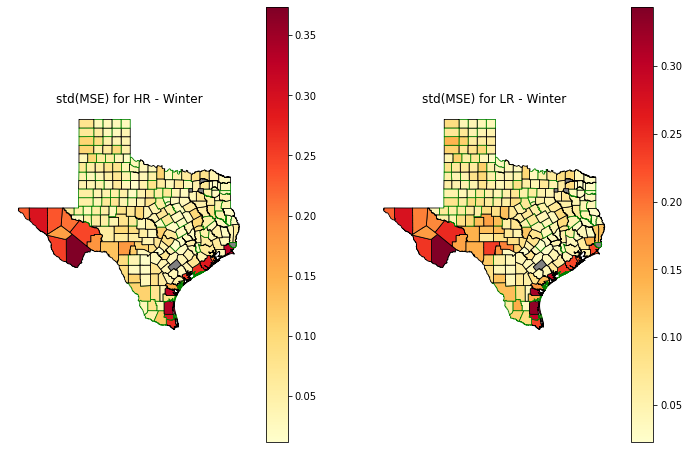

In [26]:
import geopandas as gpd
TxFarmData = pd.read_excel(Data_directory + "/WindFarmsTx.xlsx" , engine='openpyxl')
tx_counties = gpd.read_file(Data_directory + '/TexasInfo/County.shp')
county_edge_colors = {}
for name in tx_counties['CNTY_NM']:
    if name in TxFarmData['County'].values:
        county_edge_colors[name] = 'green'
    else:
        county_edge_colors[name] = 'black'
edge_colors = [county_edge_colors.get(county, 'black') for county in tx_counties['CNTY_NM']]
###Mean_MSE_data
tx_counties['Winter_HR_Mean'] = tx_counties['CNTY_NM'].map(Mean_MSE_HR_Winter)
tx_counties['Winter_LR_Mean'] = tx_counties['CNTY_NM'].map(Mean_MSE_LR_Winter)

tx_counties['Winter_HR_Max'] = tx_counties['CNTY_NM'].map(Max_MSE_HR_Winter)
tx_counties['Winter_LR_Max'] = tx_counties['CNTY_NM'].map(Max_MSE_LR_Winter)

tx_counties['Winter_HR_Min'] = tx_counties['CNTY_NM'].map(Min_MSE_HR_Winter)
tx_counties['Winter_LR_Min'] = tx_counties['CNTY_NM'].map(Min_MSE_LR_Winter)

tx_counties['Winter_HR_std'] = tx_counties['CNTY_NM'].map(std_MSE_HR_Winter)
tx_counties['Winter_LR_std'] = tx_counties['CNTY_NM'].map(std_MSE_LR_Winter)

fig, (ax1 , ax2) = plt.subplots(1, 2, figsize=(12, 8))
tx_counties.plot(column='Winter_HR_Mean', cmap='YlOrRd', linewidth=0.8, ax=ax1, edgecolor=edge_colors,missing_kwds={'color': 'gray'}, legend=True)
tx_counties.plot(column='Winter_LR_Mean', cmap='YlOrRd', linewidth=0.8, ax=ax2, edgecolor=edge_colors,missing_kwds={'color': 'gray'}, legend=True)
ax1.set_title('MSE for HR - Winter')
ax1.set_axis_off()
ax2.set_title('MSE for LR - Winter')
ax2.set_axis_off()

fig, (ax1 , ax2) = plt.subplots(1, 2, figsize=(12, 8))
tx_counties.plot(column='Winter_HR_Max', cmap='YlOrRd', linewidth=0.8, ax=ax1, edgecolor=edge_colors,missing_kwds={'color': 'gray'}, legend=True)
tx_counties.plot(column='Winter_LR_Max', cmap='YlOrRd', linewidth=0.8, ax=ax2, edgecolor=edge_colors,missing_kwds={'color': 'gray'}, legend=True)
ax1.set_title('Max(MSE) for HR - Winter')
ax1.set_axis_off()
ax2.set_title('Max(MSE) for LR - Winter')
ax2.set_axis_off()

fig, (ax1 , ax2) = plt.subplots(1, 2, figsize=(12, 8))
tx_counties.plot(column='Winter_HR_Min', cmap='YlOrRd', linewidth=0.8, ax=ax1, edgecolor=edge_colors,missing_kwds={'color': 'gray'}, legend=True)
tx_counties.plot(column='Winter_LR_Min', cmap='YlOrRd', linewidth=0.8, ax=ax2, edgecolor=edge_colors,missing_kwds={'color': 'gray'}, legend=True)
ax1.set_title('Min(MSE)for HR - Winter')
ax1.set_axis_off()
ax2.set_title('Min(MSE) for LR - Winter')
ax2.set_axis_off()

fig, (ax1 , ax2) = plt.subplots(1, 2, figsize=(12, 8))
tx_counties.plot(column='Winter_HR_std', cmap='YlOrRd', linewidth=0.8, ax=ax1, edgecolor=edge_colors,missing_kwds={'color': 'gray'}, legend=True)
tx_counties.plot(column='Winter_LR_std', cmap='YlOrRd', linewidth=0.8, ax=ax2, edgecolor=edge_colors,missing_kwds={'color': 'gray'}, legend=True)
ax1.set_title('std(MSE) for HR - Winter')
ax1.set_axis_off()
ax2.set_title('std(MSE) for LR - Winter')
ax2.set_axis_off()
#plt.savefig('texas_heatmap_.jpg')
plt.show()

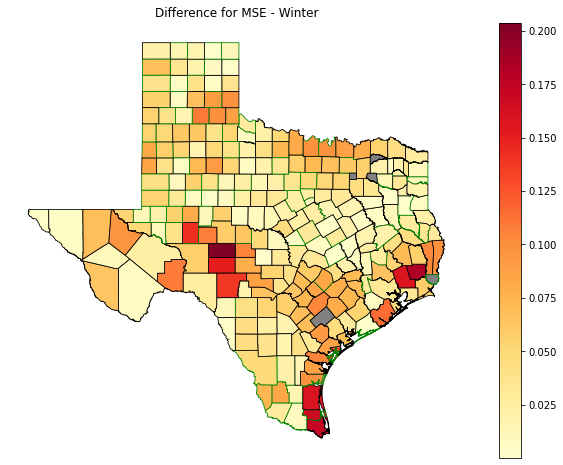

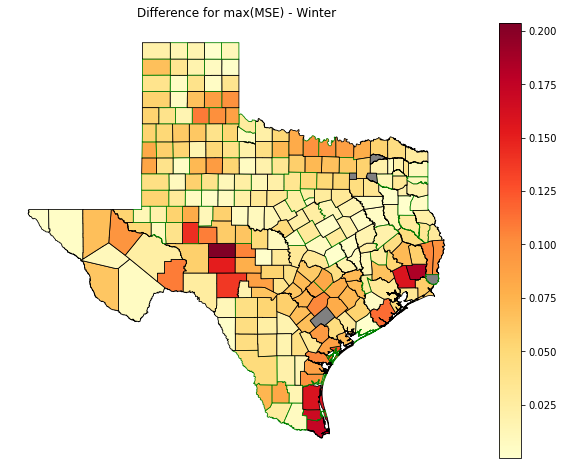

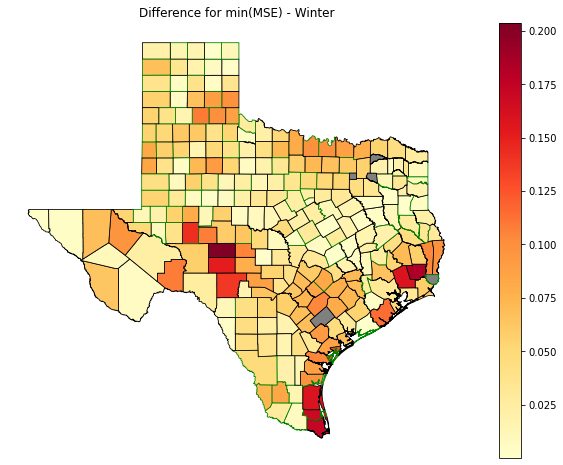

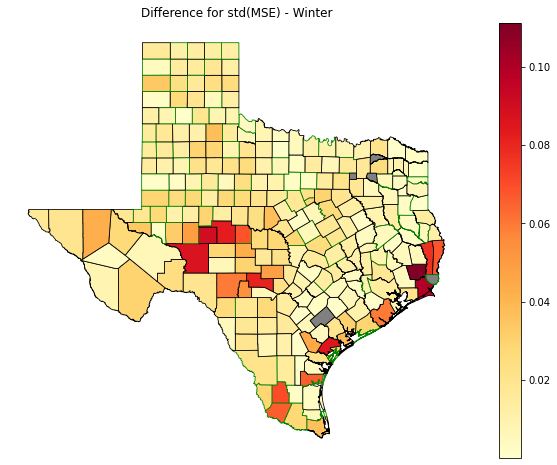

In [27]:
import geopandas as gpd
import matplotlib.pyplot as plt
diff_Mean = {}
for key,value in Mean_MSE_HR_Winter.items():
    HRval = value 
    LRval = Mean_MSE_LR_Winter[key]
    diff_Mean[key] = np.abs(HRval - LRval)
    
diff_Max = {}
for key,value in Max_MSE_HR_Winter.items():
    HRval = value 
    LRval = Max_MSE_LR_Winter[key]
    diff_Max[key] = np.abs(HRval - LRval)
    
diff_Min = {}
for key,value in Min_MSE_HR_Winter.items():
    HRval = value 
    LRval = Min_MSE_LR_Winter[key]
    diff_Min[key] = np.abs(HRval - LRval)
    
diff_std = {}
for key,value in std_MSE_HR_Winter.items():
    HRval = value 
    LRval = std_MSE_LR_Winter[key]
    diff_std[key] = np.abs(HRval - LRval)
    
tx_counties = gpd.read_file(Data_directory + '/TexasInfo/County.shp')
tx_counties['diff_Mean'] = tx_counties['CNTY_NM'].map(diff_Mean)
tx_counties['diff_Max'] = tx_counties['CNTY_NM'].map(diff_Max)
tx_counties['diff_Min'] = tx_counties['CNTY_NM'].map(diff_Min)
tx_counties['diff_std'] = tx_counties['CNTY_NM'].map(diff_std)

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
tx_counties.plot(column='diff_Mean', cmap='YlOrRd', linewidth=0.8, ax=ax, edgecolor=edge_colors,missing_kwds={'color': 'gray'}, legend=True)
ax.set_title('Difference for MSE - Winter')
ax.set_axis_off()

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
tx_counties.plot(column='diff_Max', cmap='YlOrRd', linewidth=0.8, ax=ax, edgecolor=edge_colors,missing_kwds={'color': 'gray'}, legend=True)
ax.set_title('Difference for max(MSE) - Winter')
ax.set_axis_off()

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
tx_counties.plot(column='diff_Min', cmap='YlOrRd', linewidth=0.8, ax=ax, edgecolor=edge_colors,missing_kwds={'color': 'gray'}, legend=True)
ax.set_title('Difference for min(MSE) - Winter')
ax.set_axis_off()

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
tx_counties.plot(column='diff_std', cmap='YlOrRd', linewidth=0.8, ax=ax, edgecolor=edge_colors,missing_kwds={'color': 'gray'}, legend=True)
ax.set_title('Difference for std(MSE) - Winter')
ax.set_axis_off()

plt.show()